In [1]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
if os.path.basename(os.getcwd()).lower() == "notebooks":
    os.chdir("..")

from scripts.preprocess import load_and_clean, engineer_features, build_preprocessor


In [3]:
#!/usr/bin/env python3
"""
scripts/model.py — train & evaluate baseline regressors,
skipping XGBoost if it’s not installed.
"""

import os
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model    import LinearRegression, Ridge
from sklearn.ensemble        import RandomForestRegressor
from sklearn.metrics         import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline        import Pipeline
from scripts.preprocess      import load_and_clean, engineer_features, build_preprocessor

# Try to import XGBoost; if missing, we’ll skip it
try:
    from xgboost import XGBRegressor
    _HAS_XGB = True
except ImportError:
    _HAS_XGB = False

def evaluate(name, model, X_test, y_test):
    """Utility to compute and print regression metrics."""
    y_pred = model.predict(X_test)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)
    print(f"{name:20s} → RMSE: {rmse:7.3f} | MAE: {mae:7.3f} | R²: {r2:6.3f}")
    return rmse

def main():
    # ensure project root
    if os.path.basename(os.getcwd()).lower() == "notebooks":
        os.chdir("..")

    # load & featurize
    df = load_and_clean("data/data.csv")
    df = engineer_features(df)

    # drop rows with missing target
    target = "equipment_energy_consumption"
    df = df.dropna(subset=[target])

    X = df.drop([target, "timestamp"], axis=1)
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    preprocessor = build_preprocessor(df)

    # define models
    models = {
        "LinearRegression": Pipeline([("prep", preprocessor), ("reg", LinearRegression())]),
        "Ridge(a=1)":        Pipeline([("prep", preprocessor), ("reg", Ridge(alpha=1))]),
        "RandomForest":      Pipeline([("prep", preprocessor), ("reg", RandomForestRegressor(n_estimators=100, random_state=42))]),
    }
    if _HAS_XGB:
        models["XGBoost"] = Pipeline([("prep", preprocessor),
                                      ("reg", XGBRegressor(n_estimators=100, random_state=42,
                                                            objective="reg:squarederror"))])

    # train & evaluate
    results = {}
    for name, pipe in models.items():
        print(f"\nTraining {name}...")
        pipe.fit(X_train, y_train)
        results[name] = evaluate(name, pipe, X_test, y_test)

    # save best
    best = min(results, key=results.get)
    os.makedirs("models", exist_ok=True)
    joblib.dump(models[best], f"models/{best}.pkl")
    print(f"\n✅ Saved best model `{best}` to models/{best}.pkl")

if __name__ == "__main__":
    main()



Training LinearRegression...
LinearRegression     → RMSE: 161.973 | MAE:  71.701 | R²:  0.023

Training Ridge(a=1)...
Ridge(a=1)           → RMSE: 161.973 | MAE:  71.701 | R²:  0.023

Training RandomForest...
RandomForest         → RMSE: 160.923 | MAE:  69.673 | R²:  0.035

✅ Saved best model `RandomForest` to models/RandomForest.pkl


In [4]:
# 13. Hyperparameter tuning for RandomForest 

import os
import pandas as pd
import numpy as np
from scipy.stats import randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# Imports from your preprocess script
from scripts.preprocess import load_and_clean, engineer_features, build_preprocessor

# 1. Ensure we’re at project root
if os.path.basename(os.getcwd()).lower() == "notebooks":
    os.chdir("..")

# 2. Load & clean
df = load_and_clean("data/data.csv")
df = engineer_features(df)
df = df.dropna(subset=["equipment_energy_consumption"])

# 3. Split train/test
X = df.drop(["timestamp", "equipment_energy_consumption"], axis=1)
y = df["equipment_energy_consumption"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. Build preprocessor
preprocessor = build_preprocessor(df)

# 5. Define updated parameter distributions (no 'auto')
param_dist = {
    "reg__n_estimators":      randint(50, 300),
    "reg__max_depth":         randint(5, 30),
    "reg__min_samples_split": randint(2, 10),
    "reg__min_samples_leaf":  randint(1, 5),
    "reg__max_features":      ["sqrt", "log2", None]
}

# 6. Create RF pipeline
rf_pipe = Pipeline([
    ("prep", preprocessor),
    ("reg", RandomForestRegressor(random_state=42))
])

# 7. Setup RandomizedSearchCV
rs = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=param_dist,
    n_iter=25,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    random_state=42,
    verbose=1,
    error_score="raise"
)

# 8. Fit the search
rs.fit(X_train, y_train)

# 9. Report best params and CV score
print("Best hyperparameters:\n", rs.best_params_)
print(f"Best CV RMSE: {-rs.best_score_:.3f}")

# 10. Evaluate on test set
best_rf = rs.best_estimator_
y_pred = best_rf.predict(X_test)
test_mse  = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_mae  = mean_absolute_error(y_test, y_pred)
test_r2   = r2_score(y_test, y_pred)

print(f"\nTuned RF Test Performance:\n"
      f"  RMSE: {test_rmse:.3f}\n"
      f"   MAE: {test_mae:.3f}\n"
      f"    R²: {test_r2:.3f}")

# 11. Save the tuned model
os.makedirs("models", exist_ok=True)
joblib.dump(best_rf, "models/RandomForest_tuned.pkl")
print("Saved tuned model to models/RandomForest_tuned.pkl")


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best hyperparameters:
 {'reg__max_depth': 25, 'reg__max_features': 'log2', 'reg__min_samples_leaf': 4, 'reg__min_samples_split': 5, 'reg__n_estimators': 160}
Best CV RMSE: 178.158

Tuned RF Test Performance:
  RMSE: 154.263
   MAE: 61.582
    R²: 0.114
Saved tuned model to models/RandomForest_tuned.pkl


`shap` is not installed. Falling back to built-in feature importances.
To use SHAP, install it with: pip install shap


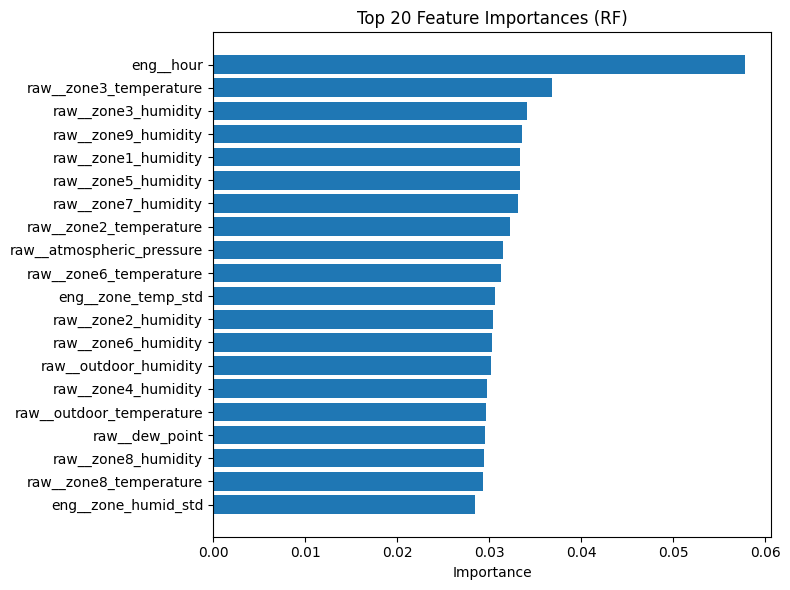

In [6]:
# 14. Model interpretation with SHAP (with fallback to feature_importances_)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

# 1. Ensure project root
if os.path.basename(os.getcwd()).lower() == "notebooks":
    os.chdir("..")

# 2. Load & engineer (so names align)
from scripts.preprocess import load_and_clean, engineer_features, build_preprocessor
df = load_and_clean("data/data.csv")
df = engineer_features(df)
df = df.dropna(subset=["equipment_energy_consumption"])

# 3. Prepare test set
from sklearn.model_selection import train_test_split
X = df.drop(["timestamp","equipment_energy_consumption"], axis=1)
_, X_test, _, _ = train_test_split(
    X,
    df["equipment_energy_consumption"],
    test_size=0.2,
    random_state=42
)

# 4. Load tuned model
best_rf = joblib.load("models/RandomForest_tuned.pkl")
preprocessor = best_rf.named_steps["prep"]
regressor    = best_rf.named_steps["reg"]

# 5. Try SHAP
try:
    import shap
    # Transform for SHAP
    X_test_trans = preprocessor.transform(X_test)
    try:
        feat_names = preprocessor.get_feature_names_out()
    except AttributeError:
        feat_names = X_test.columns
    X_test_trans = pd.DataFrame(X_test_trans, columns=feat_names)
    explainer = shap.TreeExplainer(regressor)
    sample = X_test_trans.sample(200, random_state=42)
    shap_values = explainer.shap_values(sample)

    # SHAP summary bar plot
    shap.summary_plot(shap_values, sample, plot_type="bar")
    plt.show()
    # SHAP beeswarm
    shap.summary_plot(shap_values, sample)
    plt.show()

except ModuleNotFoundError:
    print("`shap` is not installed. Falling back to built-in feature importances.\n"
          "To use SHAP, install it with: pip install shap")
    # 6. Fallback: feature_importances_
    fi = regressor.feature_importances_
    try:
        feat_names = preprocessor.get_feature_names_out()
    except AttributeError:
        feat_names = X_test.columns
    idx = np.argsort(fi)[::-1]
    top_n = 20  # plot top 20 features
    plt.figure(figsize=(8, 6))
    plt.barh(np.array(feat_names)[idx][:top_n][::-1],
             fi[idx][:top_n][::-1])
    plt.title("Top 20 Feature Importances (RF)")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()
